In [1]:
import requests
import os
import logging
from collections import Counter

# get licence data
- from turing org repos
- using github's graphql api

In [2]:
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

In [3]:
# endpoint
url = 'https://api.github.com/graphql'
token = os.environ.get('GITHUB_TOKEN')
org_name = "alan-turing-institute"

In [4]:
query = '''
query($org: String!, $cursor: String) {
  organization(login: $org) {
    repositories(first: 100, after: $cursor) {
      pageInfo {
        hasNextPage
        endCursor
      }
      nodes {
        name
        licenseInfo {
          name
        }
        isPrivate
      }
    }
  }
}
'''

In [5]:
def run_query(query, variables):
    headers = {'Authorization': f'Bearer {token}'}
    response = requests.post(url, json={'query': query, 'variables': variables}, headers=headers)
    if response.status_code == 200:
        return response.json()
    else:
        raise Exception(f"Query failed with status code: {response.status_code}")



In [6]:
def get_all_licenses():
    licenses = []
    inaccessible_repos = []
    variables = {'org': org_name, 'cursor': None}
    
    while True:
        try:
            result = run_query(query, variables)
            repos = result['data']['organization']['repositories']
            
            for repo in repos['nodes']:
                repo_name = repo['name']
                license_info = repo['licenseInfo']
                is_private = repo['isPrivate']
                #created_at = repo['createdAt']
                
                if license_info:
                    licenses.append(license_info['name'])
                    logging.info(f"Repository: {repo_name}, License: {license_info['name']}")
                else:
                    if is_private:
                        inaccessible_repos.append(repo_name)
                        logging.warning(f"No access to license info for private repository: {repo_name}")
                    else:
                        licenses.append('No license')
                        logging.info(f"Repository: {repo_name}, License: No license")
            
            if not repos['pageInfo']['hasNextPage']:
                break
            
            variables['cursor'] = repos['pageInfo']['endCursor']
        
        except Exception as e:
            logging.error(f"Error occurred while fetching data: {str(e)}")
            break
    
    return licenses, inaccessible_repos

In [7]:
logging.info(f"Starting script with token: {token[:4]}...{token[-4:]} (length: {len(token)})")
logging.info(f"Organization name: {org_name}")
    
all_licenses, inaccessible_repos= get_all_licenses()

2024-07-15 10:53:16,259 - INFO - Starting script with token: ghp_...fVTt (length: 40)
2024-07-15 10:53:16,260 - INFO - Organization name: alan-turing-institute
2024-07-15 10:53:16,899 - INFO - Repository: reveal.js, License: MIT License
2024-07-15 10:53:16,900 - WARNING - No access to license info for private repository: techreport-overview_of_data_wrangling_software
2024-07-15 10:53:16,901 - WARNING - No access to license info for private repository: howtos
2024-07-15 10:53:16,901 - INFO - Repository: templates, License: No license
2024-07-15 10:53:16,902 - WARNING - No access to license info for private repository: Hut23
2024-07-15 10:53:16,902 - INFO - Repository: network-comparison, License: MIT License
2024-07-15 10:53:16,903 - WARNING - No access to license info for private repository: wrangling-tests
2024-07-15 10:53:16,904 - INFO - Repository: data-study-group-syngenta, License: No license
2024-07-15 10:53:16,904 - WARNING - No access to license info for private repository: aid

In [8]:
len(all_licenses)
len(inaccessible_repos)

70

# plot

In [9]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

sns.set_palette("deep")

In [19]:
def categorize_license(license_name):
    permissive_licenses = [
        'MIT License', 'Apache License 2.0', 'BSD 3-Clause "New" or "Revised" License',
        'BSD 2-Clause "Simplified" License', 'ISC License', 'BSD Zero Clause License'
    ]
    copyleft_licenses = [
        'GNU General Public License v3.0', 'GNU Lesser General Public License v3.0',
        'GNU Affero General Public License v3.0', 'Mozilla Public License 2.0'
    ]
    
    if license_name in permissive_licenses:
        return 'Permissive'
    elif license_name in copyleft_licenses:
        return 'Copyleft'
    else:
        return 'Other'

In [22]:
df

,license,license_type
0,MIT License,Permissive
1,No license,Other
2,MIT License,Permissive
3,No license,Other
4,MIT License,Permissive
...,...,...
546,No license,Other
547,No license,Other
548,Creative Commons Attribution 4.0 International,Other
549,No license,Other


In [20]:
df = pd.DataFrame(all_licenses, columns=['license'])
df['license_type'] = df['license'].apply(categorize_license)
df.head()
df['license'].value_counts()

license
MIT License                                                   278
No license                                                    129
Other                                                          50
Apache License 2.0                                             28
BSD 3-Clause "New" or "Revised" License                        27
GNU General Public License v3.0                                14
Mozilla Public License 2.0                                      7
Creative Commons Attribution 4.0 International                  6
Creative Commons Zero v1.0 Universal                            5
GNU Lesser General Public License v3.0                          2
Creative Commons Attribution Share Alike 4.0 International      2
ISC License                                                     1
BSD 2-Clause "Simplified" License                               1
BSD Zero Clause License                                         1
Name: count, dtype: int64

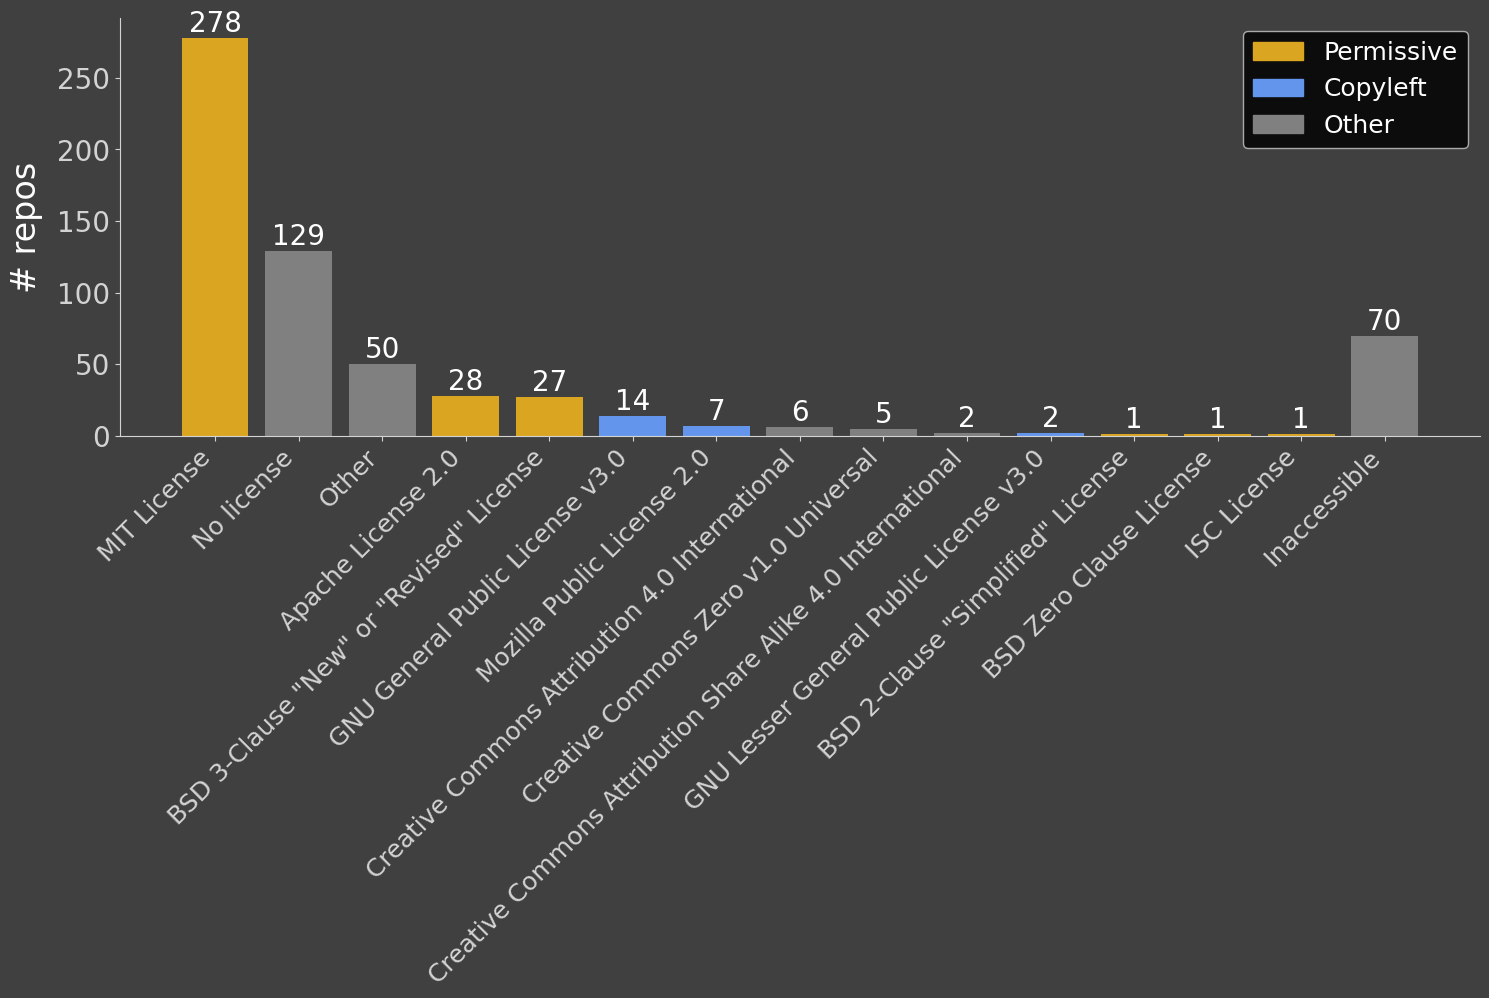

In [28]:
plt.style.use('dark_background')

fig, ax = plt.subplots(figsize=(15, 10))
fig.patch.set_facecolor('#404040')  
ax.set_facecolor('#404040') 

licence_counts = df.groupby(['license', 'license_type']).size().reset_index(name='count')
licence_counts = licence_counts.sort_values('count', ascending=False)

inaccessible_count = len(inaccessible_repos)
licence_counts = pd.concat([licence_counts, 
                            pd.DataFrame({'license': ['Inaccessible'], 
                                          'license_type': ['Other'], 
                                          'count': [inaccessible_count]})], 
                           ignore_index=True)

color_map = {'Permissive': 'goldenrod', 'Copyleft': 'cornflowerblue', 'Other': 'grey'}

bars = ax.bar(licence_counts['license'], licence_counts['count'], 
              color=licence_counts['license_type'].map(color_map))

ax.set_ylabel('# repos', fontsize=24, labelpad=10, color='white')
ax.set_xlabel('')

plt.xticks(rotation=45, ha='right', fontsize=18, color='lightgrey')
plt.yticks(fontsize=20, color='lightgrey')

for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{height}', ha='center', va='bottom', color='white', fontsize=20)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_color('lightgrey')
ax.spines['left'].set_color('lightgrey')

ax.tick_params(axis='x', colors='lightgrey')
ax.tick_params(axis='y', colors='lightgrey')

handles = [plt.Rectangle((0,0),1,1, color=color) for color in color_map.values()]
plt.legend(handles, color_map.keys(), loc='upper right', fontsize=18)

plt.tight_layout()

plt.savefig('turing_licenses_plot_colored.png', format='png', dpi=1200, bbox_inches='tight', transparent=True)
plt.show()

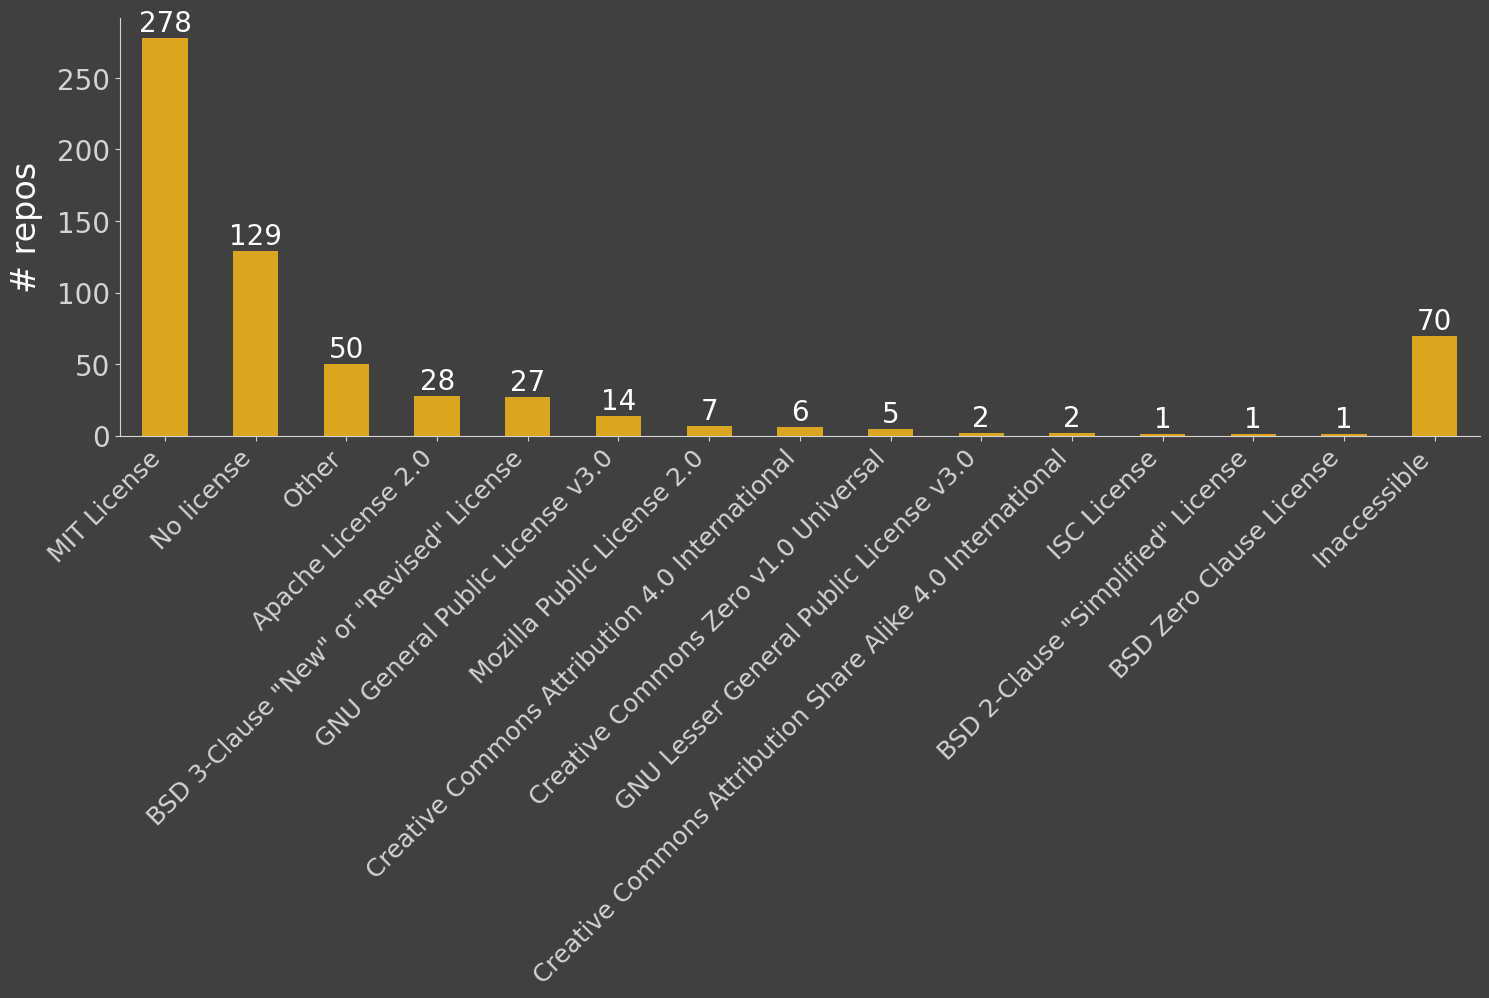

In [18]:
plt.style.use('dark_background')

fig, ax = plt.subplots(figsize=(15, 10))
fig.patch.set_facecolor('#404040')  
ax.set_facecolor('#404040') 

licence_counts = df['license'].value_counts()
licence_counts['Inaccessible'] = len(inaccessible_repos)

licence_counts_sorted = licence_counts.sort_values(ascending=False)
inaccessible_count = licence_counts_sorted.pop('Inaccessible')
licence_counts_sorted = pd.concat([licence_counts_sorted, pd.Series({'Inaccessible': inaccessible_count})])

licence_counts_sorted.plot(kind='bar', ax=ax, color='goldenrod')

#ax.set_title('Licences in Turing repos', fontsize=24, fontweight='bold', pad=20, color='white')
ax.set_ylabel('# repos', fontsize=24, labelpad=10, color='white')
ax.set_xlabel('')

plt.xticks(rotation=45, ha='right', fontsize=18, color='lightgrey')
plt.yticks(fontsize=20, color='lightgrey')

for i, v in enumerate(licence_counts_sorted):
    ax.text(i, v + 0.5, str(v), ha='center', va='bottom', color='white', fontsize=20)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_color('lightgrey')
ax.spines['left'].set_color('lightgrey')

ax.tick_params(axis='x', colors='lightgrey')
ax.tick_params(axis='y', colors='lightgrey')

plt.tight_layout()

plt.savefig('turing_licenses_plot.png', format='png', dpi=1200, bbox_inches='tight', transparent=True)
